<a href="https://colab.research.google.com/github/Alexflames/risks-code/blob/master/Gravitymodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

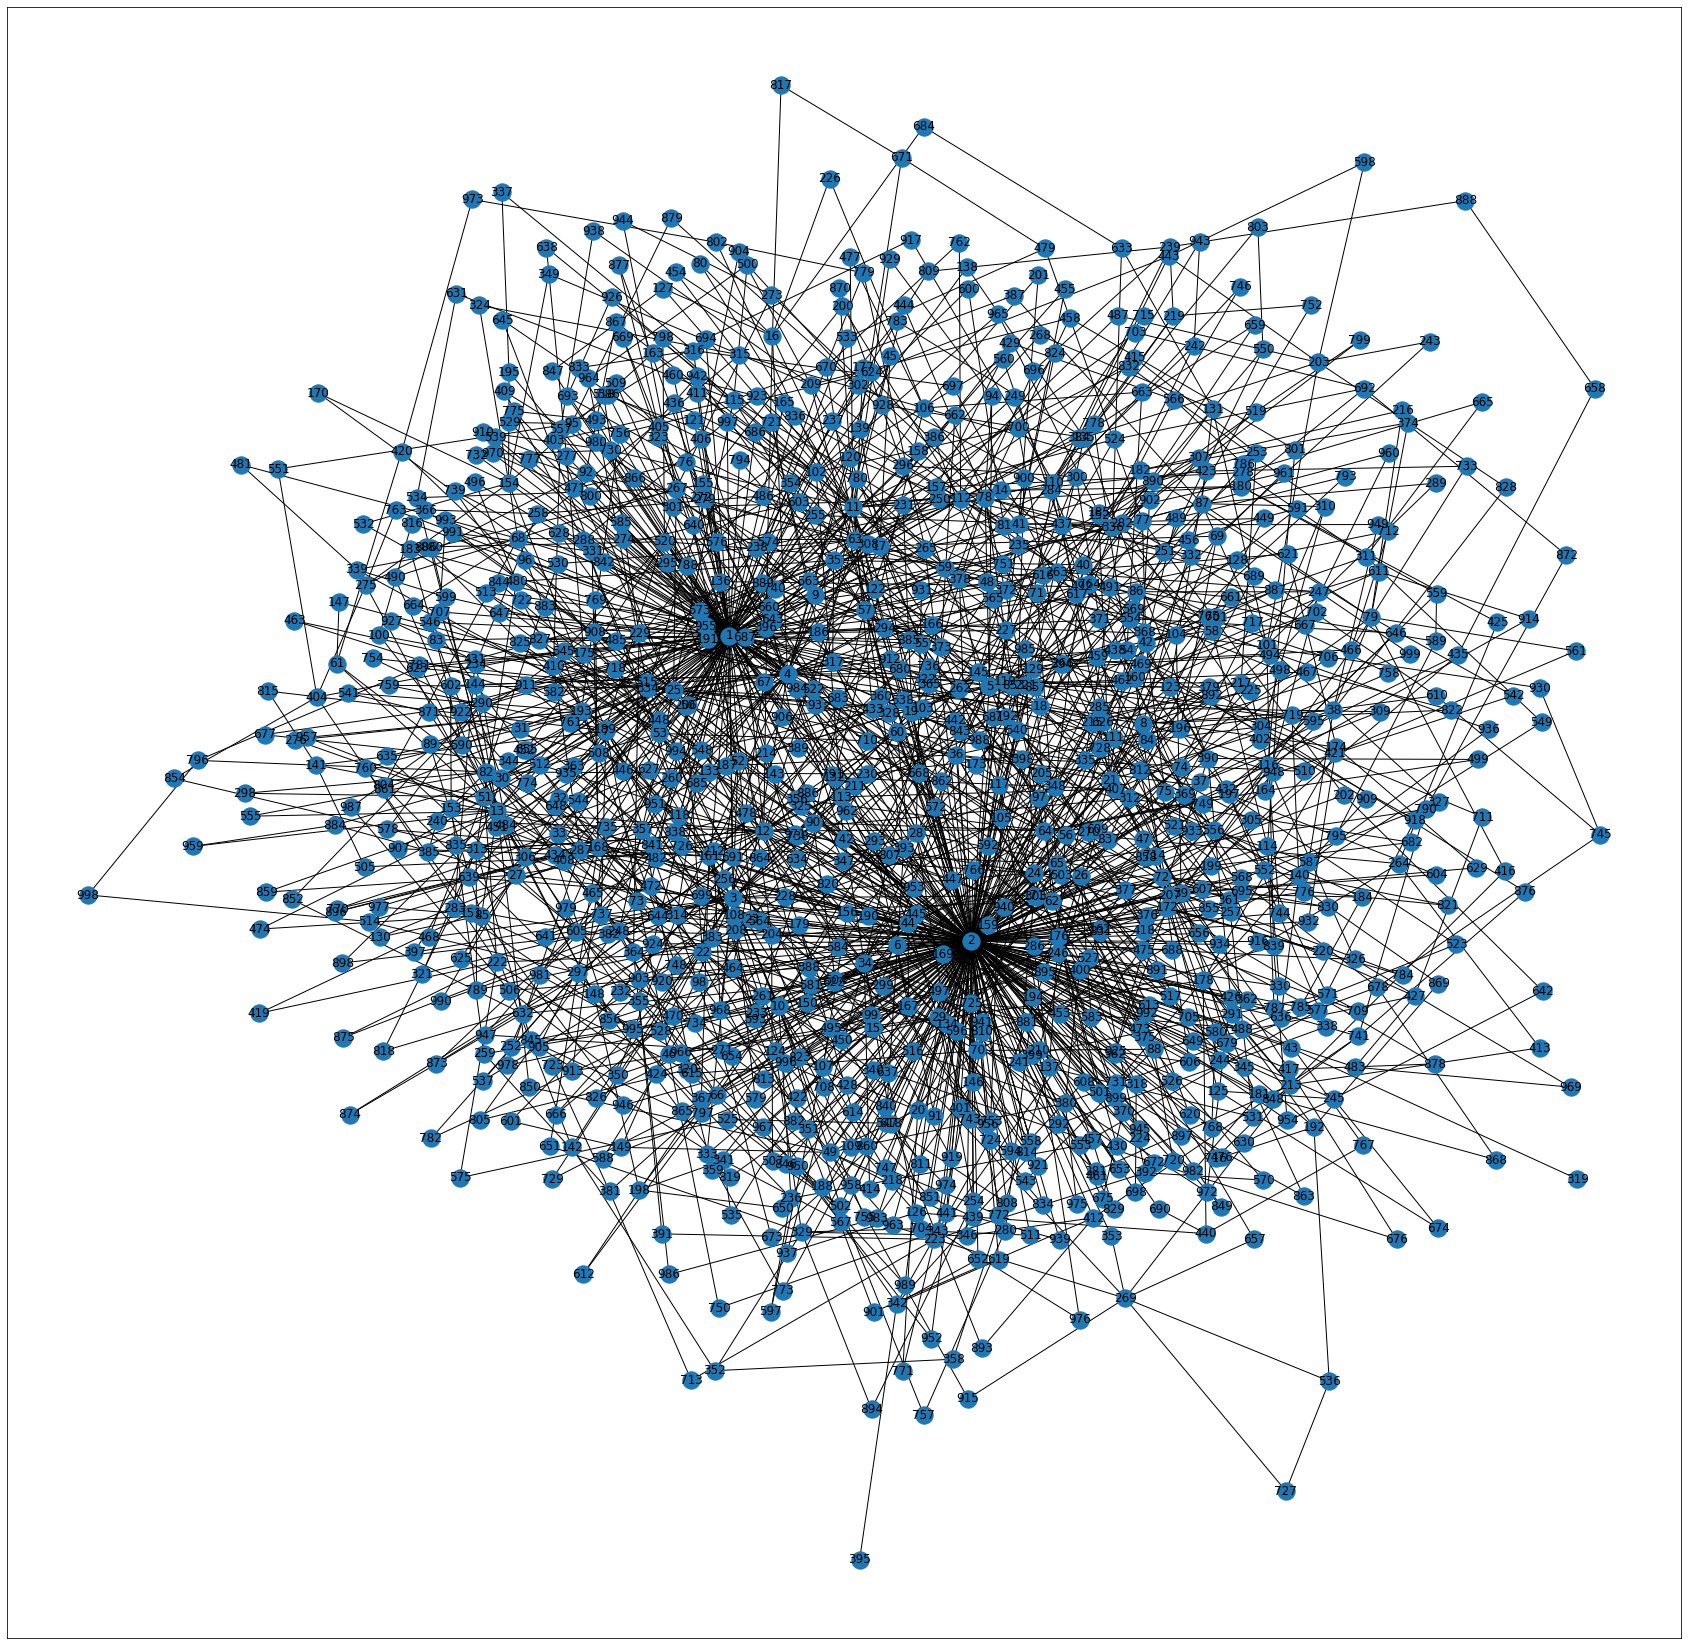

In [1]:
import networkx as nx
import random as rand
import matplotlib.pyplot as plt

def binarySearch(data, val):
    highIndex = len(data)-1
    lowIndex = 0
    while highIndex > lowIndex:
            index = (highIndex + lowIndex) // 2
            sub = data[index]
            if data[lowIndex] == val:
                    return [lowIndex, lowIndex]
            elif sub == val:
                    return [index, index]
            elif data[highIndex] == val:
                    return [highIndex, highIndex]
            elif sub > val:
                    if highIndex == index:
                            return sorted([highIndex, lowIndex])
                    highIndex = index
            else:
                    if lowIndex == index:
                            return sorted([highIndex, lowIndex])
                    lowIndex = index
    return sorted([highIndex, lowIndex])

class Gravitymodel:

  def compute_probability_range(self, array, sum_array, tuple_length = 1, tuple_i = 1):
    value_p_range = [0]
    for (j, value) in enumerate(array):
      if tuple_length != 1:
        value_p_range.append((value[tuple_i] / sum_array) + value_p_range[j])
      else:
        value_p_range.append((value / sum_array) + value_p_range[j])
    return value_p_range[1:]
  

  def distribution_to_file(self, filename):
    graph = self.graph
    sum_degrees = 2 * len(graph.edges)
    distribution = [0] + self.compute_probability_range(graph.degree, sum_degrees, 2, 1)

    f = open(filename, 'w')
    for i in range(self.n):
      f.write("{0:.4f}".format(distribution[i]) + '\n')

  
  def adjacency_matrix_to_file(self, filename):
    graph = self.graph
    adj_matrix = nx.adjacency_matrix(graph, weight=None)

    f = open(filename, 'w')
    for i in graph.nodes():
      for j in graph.nodes():
        f.write(str(1 if graph.has_edge(i, j) else 0) + ' ')
      f.write('\n')

    f.close()


  def __init__(self, n):
    # Preparation: 2 connected nodes
    self.graph = nx.Graph()
    self.graph.add_nodes_from([1, 2])
    self.graph.add_edge(1, 2)
    self.n = n

    # Main algorithm
    graph = self.graph
    for i in range(3, n):
      sum_degrees = 2 * len(graph.edges)
      
      degree_p_range = self.compute_probability_range(graph.degree, sum_degrees, 2, 1)
      # Insert edge number 1
      
      choice = rand.random()
      graph.add_node(i)
      node_to_chosen = binarySearch(degree_p_range, choice)[1]
      graph.add_edge(i, node_to_chosen + 1)

      # Insert edge number 2
      paths = nx.single_source_shortest_path_length(graph, node_to_chosen + 1)
      # Formula for probability: dj / (Rij^2) 
      paths_list = [graph.degree[key] / (paths[key] ** 2 if paths[key] != 0 else len(graph.nodes) ** 2) for key in sorted(paths.keys())]
      p_range2 = self.compute_probability_range(paths_list, sum(paths_list))
      choice2 = rand.random()
      node_to_chosen = binarySearch(p_range2, choice2)[1]
      graph.add_edge(i, node_to_chosen + 1)
      
      #print(i, degree_p_range, graph.edges, "\n")
    
    plt.figure(3,figsize=(30,30)) 
    nx.draw_networkx(graph)
    self.distribution_to_file("distribution.txt")
    self.adjacency_matrix_to_file("matrix.txt")
    

test = Gravitymodel(1000)

In [0]:
#%debug

In [0]:
# with open('matrix.txt', 'r') as f:
#     lines = f.read()
#     print(lines)

In [0]:
# activate R magic
%load_ext rpy2.ipython

In [0]:
%%R
logbin <- function(x, y = NULL, n) {
  logx <- log10(x)                                           # log transform x value (biomass)
  bin_edges <- seq(min(logx), max(logx), length.out = n + 1) # get edges of bins
  logxbin <- rep(NA, length(logx))                           # create data structure to assign trees to bins
  b <- bin_edges                                             # add a little to the biggest bin temporarily
  b[length(b)] <- b[length(b)] + 1                           # (so that the biggest single tree is put in a bin)
  for (i in 1:length(logx)) {
    logxbin[i] <- sum(logx[i] >= b)                          # assign each tree to a bin
  }
  bin_midpoints <- numeric(n)
  for (i in 1:n) {
    bin_midpoints[i] <- mean(10^(bin_edges[i:(i+1)]))        # backtransform bin edges to linear, and get midpoints
  }
  bin_widths <- diff(10^bin_edges)                           # get linear width of each bin
  bin_factor <- factor(logxbin, levels=1:n)                  # convert bin to factor (required to deal with zeroes if present)
  bin_counts <- table(bin_factor)                            # find number of trees in each bin
  if (!is.null(y)) {
    rawy <- tapply(y, bin_factor, sum)                       # sum y value (production) in each bin
    rawy[is.na(rawy)] <- 0                                   # add zeroes back in if present
    bin_values <- as.numeric(rawy/bin_widths)                # divide production by width for each bin 
  }
  else {
    bin_values <- as.numeric(bin_counts/bin_widths)          # 1-dimensional case.
  }
  
  return(data.frame(bin_midpoint = bin_midpoints,            # return result!
                    bin_value = bin_values,                  # also add bin min and max for bar plot purposes
                    bin_count = as.numeric(bin_counts),
                    bin_min = 10^bin_edges[1:n],
                    bin_max = 10^bin_edges[2:(n+1)]))
  
}

[1] 5


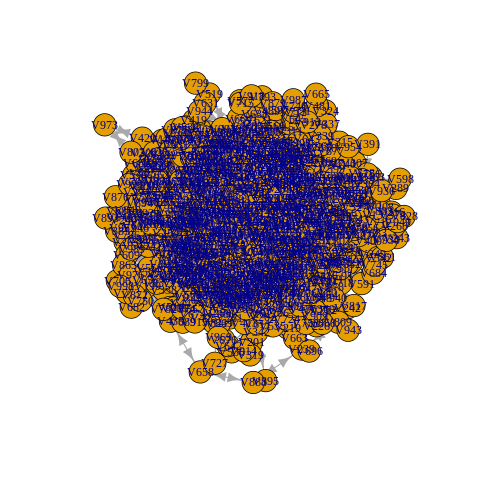

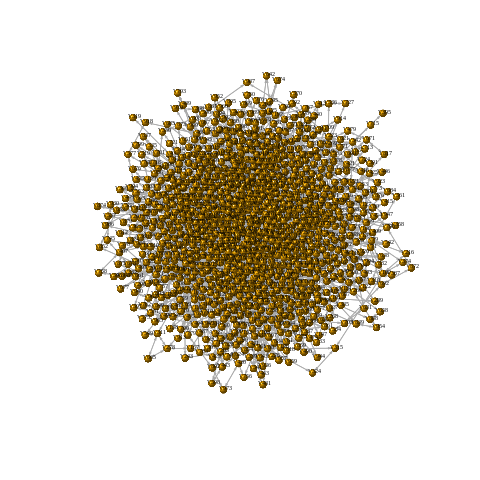

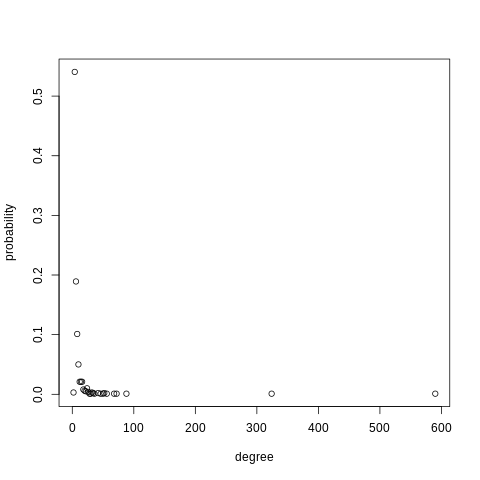

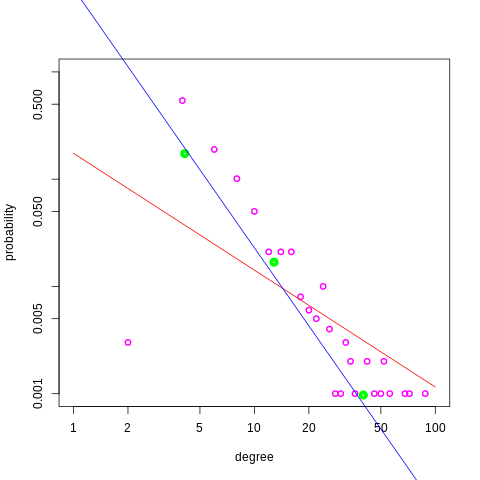

In [10]:
%%R
#install.packages("igraph")
library(igraph)
gravity=read.table("matrix.txt",sep="")
gravity=as.matrix(gravity)
k=7
cozf=matrix(NA,1,2)
cozf2=matrix(NA,1,2)
R1=matrix(NA,1,1)
R2=  matrix(NA,1,1)


g=graph_from_adjacency_matrix(gravity,diag = F)
plot(g)
plot(g, edge.arrow.size=.2, vertex.size = 5,	 edge.curved=0, 
     vertex.label.color = "black", vertex.label.dist = 0.2, vertex.label.cex=.5,  
     layout = layout_with_graphopt(g), vertex.shape = "sphere")
d = degree(g, mode = "all")
dd = degree.distribution(g,mode = "all", cumulative = FALSE)
#plot(dd) 
probability = dd[-1] 
nonzero.position = which(probability != 0)
probability = probability[nonzero.position]
degree = 1:max(d)
degree = degree[nonzero.position]
reg = lm(log(probability) ~ log(degree))
R1=summary(reg)$r.square
cozf = coef(reg)
cozf
plot(probability ~degree)

plot(probability ~ degree, log = "xy", xlim = c(1,100), ylim = c(1e-03,1), lwd=2, col =14)

power.law.fit = function(x) exp(cozf[1]+cozf[2]*log(x))
curve(power.law.fit, col = "red", add = T)


lbin <- logbin(x = degree, y = probability, k)
repeat {
  if(any(lbin$bin_value == 0)){
  k=k-1
  lbin <- logbin(x = degree, y = probability, k)
  } 
  
  else break
}
print(k)
k=7
regbin = lm(log(lbin$bin_value)~ log(lbin$bin_midpoint))
R2=summary(regbin)$r.square
cozf2 = coef(regbin)

 lines(lbin$bin_midpoint, lbin$bin_value, col ="green" , type = 'p', lwd=5)
 power.law.fit2 = function(x) exp(cozf2[1]+cozf2[2]*log(x))
 curve(power.law.fit2, col = "blue", add = T)

In [11]:
%%R
print(-cozf2[2])
print(R2)

log(lbin$bin_midpoint) 
              2.416336 
[1] 0.9877901
